In [24]:
import matplotlib.pyplot as plt
import pyocto
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from src.seismicity_samples_Dieterich94 import \
    get_seismicity_sample_from_Dieterich94, get_rectangular_slippatch_from_FM, \
        plot_rectangular_slippatch, set_bounding_box
from src.generate_poisson import plot_poisson, generate_poisson_events
from src.butler_vanaswegen import Butler_VanAswegen_1993
from gamma.utils import association
from src.simulate_magnitudes import simulate_magnitudes

In [25]:
# !pip install git+https://github.com/wayneweiqiang/GaMMA.git
# !pip install pyocto

Get Station Coordinates

In [26]:
stations = pd.read_csv('stations/station_cords_blab_VALTER.csv')

stations.rename(columns={'station_code': 'id'}, inplace=True)
stations.drop(columns=['network_code', 'location_code','chanel_code'], inplace=True)

stations_coords = stations[['id', 'longitude', 'latitude', 'elevation']]
stations_enu = stations[['id', 'x', 'y', 'z']]

Generate earthquake locations using the center of the volume as the reference point.

In [27]:
# Specify reference focal mechanism
stk0 = 45
dip0 = 40

# Specify hypocentral coordinates, magnitude & stressdrop
e0 = stations['x'].mean()
n0 = stations['y'].mean()
u0 = stations['z'].mean()

mag = 3  # Source size
stressdrop = 1e6  # [Pa]

# Plot properties
view_angle = [-3, 90]
plotme = True

In [28]:
finsrc = get_rectangular_slippatch_from_FM(
        e0, n0, u0, stk0, dip0, mag, stressdrop)

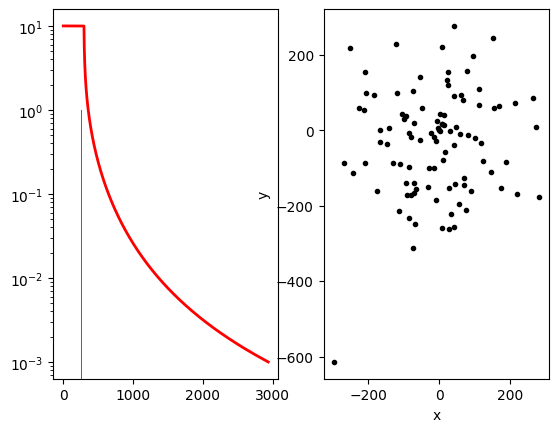

In [29]:
# Create synthetic set of FMs
neq = 100  # Number of quakes
cradius = finsrc['length']  # Crack radius, defines cluster size
dx = cradius / 20  # Stdev of scatter around perfect plane

catalog = get_seismicity_sample_from_Dieterich94(
    neq, e0, n0, u0, stk0, dip0, cradius, dx, plotme)

Plot the earthquake locations (black) and the station coordinates (red).

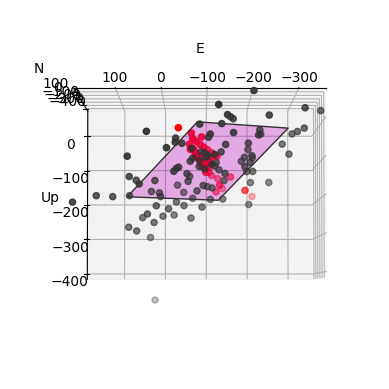

In [30]:
# 3D hypocentre distribution & finite slip patch
fig = plt.figure(204)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('E')
ax.set_ylabel('N')
ax.set_zlabel('Up')
ax.view_init(view_angle[0], view_angle[1])

# Plot rectangular slip patch
plot_rectangular_slippatch(ax, finsrc, 'm')

# Plot hypocentres
ax.scatter(catalog['e'], catalog['n'], catalog['u'], '.', color=[.2, .2, .2])
ax.scatter(stations_enu['x'], stations_enu['y'], stations_enu['z'], 'o', color='r')

XYZ = np.array([catalog['e'], catalog['n'], catalog['u']]).T

# Set plotting box
set_bounding_box(ax, XYZ, 0.4, 99.6)

plt.show()

In [31]:
catalog.keys()

dict_keys(['mname', 'crad', 'ri', 'xi', 'yi', 'e', 'n', 'u', 'azi', 'dip', 'stress', 'prop'])

Create non-clustered earthquake event times using a poissonian process.

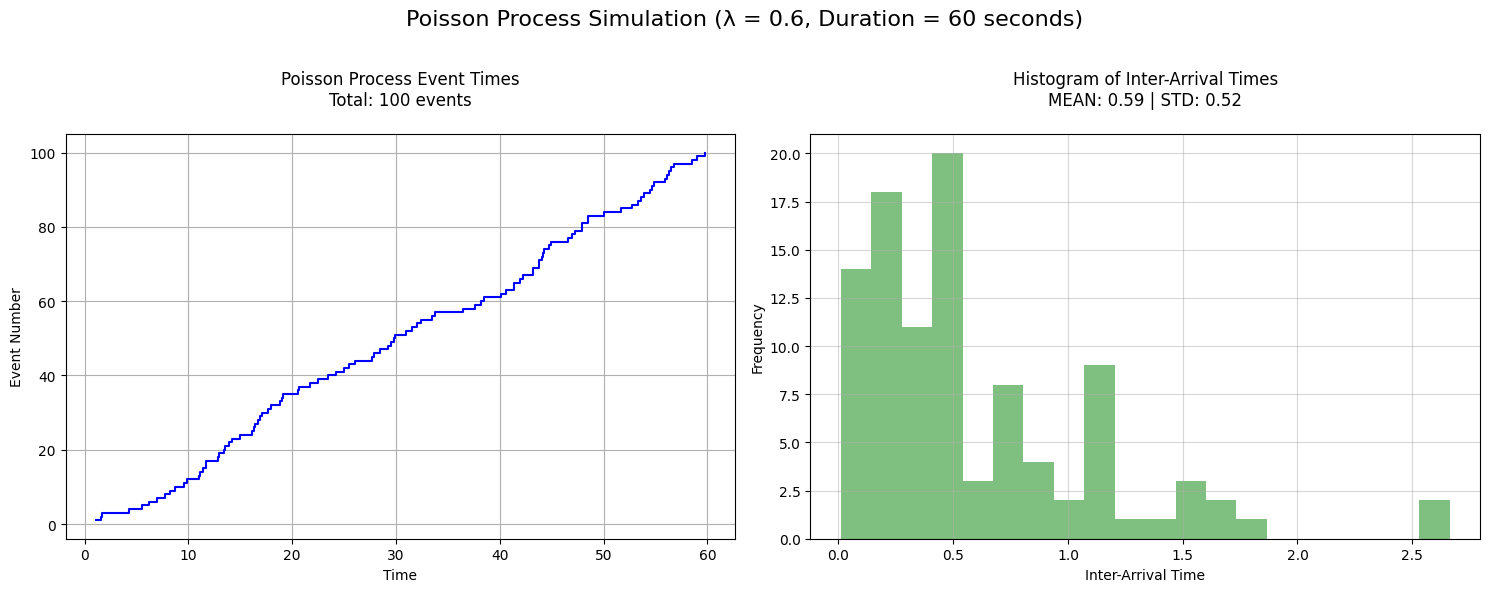

In [32]:

time_duration = 60 # seconds
size = len(catalog['e'])

rate = time_duration/size

event_times = generate_poisson_events(rate, size)

plot_poisson(event_times, rate, time_duration)


Calculate distances between event locations and stations.

In [33]:
keep = ['e', 'n', 'u']
catalog = pd.DataFrame({k: catalog[k] for k in keep})
catalog['time'] = event_times

In [34]:
dist = distance_matrix(catalog[['e', 'n', 'u']], stations_enu[['x', 'y', 'z']])
dist.shape

(100, 42)

-2.4453426833892236


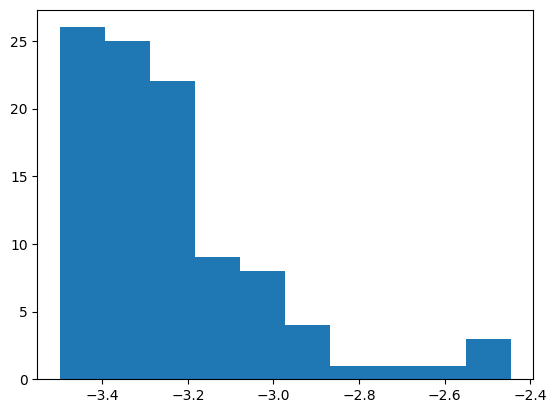

In [35]:
mags = simulate_magnitudes(size, 1.6*np.log(10), -3.5)
catalog['magnitude'] = mags

print(max(mags))
plt.hist(mags)
plt.show() 

In [36]:
v_p = 5500. #m/s
v_s = 2700. #m/s

# arrival times
at_p = dist/v_p + event_times[:, np.newaxis]
at_s = dist/v_s + event_times[:, np.newaxis]

at_s.shape

(100, 42)

In [37]:
dist_zero = distance_matrix(np.zeros((1,3)), stations_enu[['x', 'y', 'z']])

Plot arrival time vs distance from origin (0,0,0) for each event.

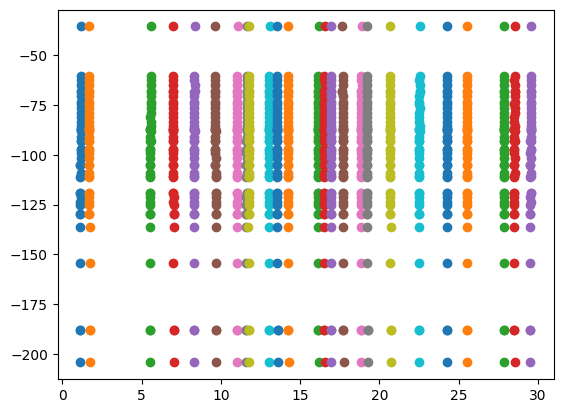

In [39]:
# plt.scatter(at_s[0,:], dist_zero[0,:])
# plt.scatter(at_s[1,:], dist_zero[0,:])
for i in range(0,50,2):
    # plt.scatter(at_s[i,:], dist_zero[0,:])
    plt.scatter(at_s[i,:], stations_enu['x'])
plt.show()

Start Calculating GMV's for each event, measured at each station.

In [40]:
def butler_proxy(distances):
    bva = np.vectorize(Butler_VanAswegen_1993)
    return bva(mags, distances)[0]
gmvs = np.apply_along_axis(butler_proxy, 0, dist)
gmvs.shape

(100, 42)

Define a cutoff, use p-th percentile of the GMV's as the cutoff.

In [41]:
cutoff = np.percentile(gmvs, 0)
detection_mask = gmvs > cutoff
detection_mask_np = detection_mask.ravel()
event_indices, station_indices = np.unravel_index(np.arange(at_p.size), at_p.shape)

phase_p = np.full_like(event_indices, 'P', dtype='U1')
phase_s = np.full_like(event_indices, 'S', dtype='U1')

at_p_np = np.column_stack((event_indices, station_indices, at_p.ravel(), phase_p))[detection_mask_np]
at_s_np = np.column_stack((event_indices, station_indices, at_s.ravel(), phase_s))[detection_mask_np]

arrivals = np.vstack((at_p_np, at_s_np))
dt = [('event', 'i8'), ('station', 'i8'), ('time', 'f8'), ('phase', 'U1')]
arrivals = pd.DataFrame(np.rec.fromarrays(arrivals.T, dtype=dt))
arrivals['station'] = arrivals['station'].map(stations_enu['id'])
arrivals_train = arrivals.drop(columns=['event'])
arrivals

,event,station,time,phase
0,0,V0509,1.128748,P
1,0,V0807,1.124031,P
2,0,V0303,1.118282,P
3,0,V0403,1.117119,P
4,0,V0414,1.126433,P
...,...,...,...,...
8393,99,V0412,59.767444,S
8394,99,V0417,59.782911,S
8395,99,V0105,59.794162,S
8396,99,V0404,59.779554,S


In [42]:
velocity_model = pyocto.VelocityModel0D(
    p_velocity=5.5,#5.5,
    s_velocity=2.7,#2.7,
    tolerance=0.1,
)

associator = pyocto.OctoAssociator.from_area(
    lat=(46.4, 46.6),
    lon=(8.4, 8.6),
    zlim=(-1, -2),
    # lat=(46,47),
    # lon=(8,9),
    # zlim=(-1,-3),
    
    time_before=0.1,#300,
    
    velocity_model=velocity_model,
    
    n_picks=12,
    n_p_and_s_picks=6,
    # n_p_picks=4, 
    # n_s_picks=4,

    min_node_size=5e-1, #10.0, 
    min_node_size_location=0.75e-1, #1.5,
    
    pick_match_tolerance=1.5, #1.5,
    
    min_interevent_time=0.0001, #3.0,
    exponential_edt=False, 
    edt_pick_std=1.0,#1.0, 
    max_pick_overlap=4, #4,
 
    refinement_iterations=3,#3, 
    time_slicing=0.5, #1200.0, 
    node_log_interval=0,#0, 
    
    location_split_depth=6,#6, 
    location_split_return=4,#4,
    min_pick_fraction=0.25
)
associator.transform_stations(stations_coords)
# stations_coords
None


The required number of P picks per event (3) is lower than the number of stations with both P and S pick (6). The effective number of P picks required will be 6.
The required number of S picks per event (3) is lower than the number of stations with both P and S pick (6). The effective number of S picks required will be 6.
/home/nicolas/workspaces/TinyQuakes/env/lib/python3.10/site-packages/pyocto/associator.py:878: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations["x"] = stations.apply(
/home/nicolas/workspaces/TinyQuakes/env/lib/python3.10/site-packages/pyocto/associator.py:883: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [43]:
arrivals_train

,station,time,phase
0,V0509,1.128748,P
1,V0807,1.124031,P
2,V0303,1.118282,P
3,V0403,1.117119,P
4,V0414,1.126433,P
...,...,...,...
8393,V0412,59.767444,S
8394,V0417,59.782911,S
8395,V0105,59.794162,S
8396,V0404,59.779554,S


In [44]:
events, assignments = associator.associate(arrivals_train, stations_coords)
# Events Found
print(f'Found {len(events)} out of {len(arrivals["event"].unique())} events')

pr = []
for i in range(len(events)):
    assignment_picks = assignments[assignments['event_idx']==i]
    picks = arrivals.iloc[assignment_picks['pick_idx']]
    correct = len(picks[picks['event']==picks['event'].mode().values[0]])
    total = len(assignment_picks)
    pr.append(correct/total)
print(f'Average Precision: {np.mean(pr)}')

Found 65 out of 100 events
Average Precision: 0.9322344322344324


In [45]:
re = []
for i in range(len(events)):
    relevant = len(arrivals[arrivals['event']==i])
    re.append(correct/relevant)
print(f'Average Recall: {np.mean(re)}')

Average Recall: 0.9884660055391764


In [22]:
arrivals_train_gamma = arrivals_train.copy()
arrivals_train_gamma.rename(columns={'time': 'timestamp', 'phase':'type', 'station': 'id'}, inplace=True)
arrivals_train_gamma['prob'] = 0.9
arrivals_train_gamma['timestamp'] = pd.to_datetime(arrivals_train_gamma['timestamp'], unit='s')
arrivals_train_gamma['type'] = arrivals_train_gamma['type'].str.lower()


stations_gamma = stations_enu.copy()
stations_gamma.rename(columns={'x': 'x(km)', 'y': 'y(km)', 'z': 'z(km)'}, inplace=True)
stations_gamma['x(km)'] = stations_gamma['x(km)'] / -1e3
stations_gamma['y(km)'] = stations_gamma['y(km)'] / -1e3
stations_gamma['z(km)'] = stations_gamma['z(km)'] / -1e3

# arrivals_train_gamma
stations_gamma

,id,x(km),y(km),z(km)
0,V0509,0.070627,0.035838,0.069560
1,V0807,0.090957,0.039659,0.116210
2,V0303,0.119436,0.063368,0.083554
3,V0403,0.129612,0.100482,0.162417
4,V0414,0.074712,0.046885,0.086544
5,V0811,0.073599,0.018942,0.079648
6,V0307,0.093298,0.037229,0.063201
7,V0812,0.068343,0.013077,0.068898
8,V0703,0.064787,0.016208,0.026382
9,V0508,0.080993,0.046200,0.083676


In [23]:
# Gamma
config = {}
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["use_dbscan"] = True
config["use_amplitude"] = False
config["x(km)"] = (0, 1)
config["y(km)"] = (0, 1)
config["z(km)"] = (0, 1)
config["vel"] = {"p": 5.5, "s": 2.7}
config["method"] = "BGMM"
if config["method"] == "BGMM":
    config["oversample_factor"] = 4
if config["method"] == "GMM":
    config["oversample_factor"] = 1

# DBSCAN
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 0.1, config["x(km)"][1] + 0.1),  # x
    (config["y(km)"][0] - 0.1, config["y(km)"][1] + 0.1),  # y
    (0, config["z(km)"][1] + 0.1),  # x
    (None, None),  # t
)
config["dbscan_eps"] = 25  # seconds
config["dbscan_min_samples"] = 3

# Filtering
config["min_picks_per_eq"] = 5
config["max_sigma11"] = 2.0
config["max_sigma22"] = 1.0
config["max_sigma12"] = 1.0

In [24]:
catalogs, assignments = association(arrivals_train_gamma, stations_gamma, config, method=config["method"])

catalog = pd.DataFrame(catalogs)
assignments = pd.DataFrame(assignments, columns=["pick_index", "event_index", "gamma_score"])

Associating 8400 picks with 1 CPUs
.
Initialization 1 did not converge.


In [25]:
catalog

,time,magnitude,sigma_time,sigma_amp,cov_time_amp,gamma_score,num_picks,num_p_picks,num_s_picks,event_index,x(km),y(km),z(km)
0,1970-01-01T00:00:01.597,999,0.518766,0,0,154.944096,84,42,42,1,0.099814,0.050136,0.096648
1,1970-01-01T00:00:01.903,999,0.718670,0,0,142.351145,84,42,42,2,0.104174,0.059351,0.105840
2,1970-01-01T00:00:04.960,999,0.590980,0,0,191.782478,84,42,42,3,0.110595,0.057468,0.100730
3,1970-01-01T00:00:04.539,999,0.399117,0,0,625.897395,84,42,42,4,0.098413,0.053339,0.104144
4,1970-01-01T00:00:06.706,999,0.508000,0,0,106.221807,84,42,42,5,0.086739,0.049330,0.106628
5,1970-01-01T00:00:10.128,999,0.983766,0,0,185.785469,84,42,42,6,0.103040,0.054307,0.099010
6,1970-01-01T00:00:15.208,999,1.079065,0,0,277.769428,84,42,42,7,0.107524,0.055460,0.098094
7,1970-01-01T00:00:18.840,999,0.686980,0,0,96.441111,84,42,42,8,0.103877,0.055255,0.100418
8,1970-01-01T00:00:21.872,999,1.413826,0,0,32.771897,84,42,42,9,0.101228,0.048381,0.100224
9,1970-01-01T00:00:27.903,999,0.973129,0,0,117.470249,84,42,42,10,0.108472,0.055403,0.098924


In [37]:
assignments

,pick_index,event_index,gamma_score
0,0,1,0.017363
1,1,1,0.017363
2,2,1,0.017363
3,3,1,0.017363
4,4,1,0.017363
...,...,...,...
1853,2495,35,0.046802
1854,2496,35,0.046802
1855,2497,35,0.046802
1856,2498,35,0.046802
